In [1]:
import os
import cv2
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.callbacks import LearningRateScheduler
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
image_path = sorted(os.listdir("../input/tray-food-segmentation/TrayDataset/TrayDataset/XTrain"))
label_path = sorted(os.listdir("../input/tray-food-segmentation/TrayDataset/TrayDataset/yTrain"))

In [3]:
def load_images(inputdir, inputpath, imagesize):
    imglist = []
    
    for i in range(len(inputpath)):
        img = cv2.imread(inputdir+inputpath[i], cv2.IMREAD_COLOR) 
        img = cv2.resize(img, (imagesize, imagesize), interpolation = cv2.INTER_AREA)
        img = img[::-1] 
        imglist.append(img)
        
    return imglist

Enhance the shading of the original segmentation image

In [4]:
def segment(label, img_size):
    labels = []
    
    for i in range(len(label)):
        tmp = label[i].flatten()
        for j in range(len(tmp)):
            if tmp[j] > 10:
                tmp[j] = 200
                
        labels.append(tmp.reshape(img_size,img_size,3))
        
    return labels

In [5]:
IMAGE_SIZE = 128

image = load_images("../input/tray-food-segmentation/TrayDataset/TrayDataset/XTrain/", image_path, IMAGE_SIZE)
before_label = load_images("../input/tray-food-segmentation/TrayDataset/TrayDataset/yTrain/", label_path, IMAGE_SIZE)

after_label = segment(before_label, IMAGE_SIZE)

image /= np.max(image)
after_label /= np.max(after_label)

# Visualize train images

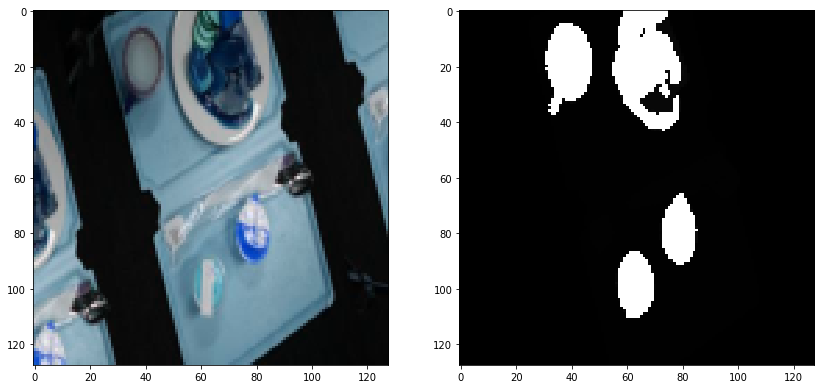

In [6]:
num = 50

plt.figure(figsize=(14, 7))

ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(image[num]))

ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(after_label[num]))

# Create model Unet

In [7]:
def Unet():
    input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    enc1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(input_img)
    enc1 = BatchNormalization()(enc1)
    enc1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(enc1)
    enc1 = BatchNormalization()(enc1)
    down1 = MaxPooling2D(pool_size=2, strides=2)(enc1)
    
    enc2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(down1)
    enc2 = BatchNormalization()(enc2)
    enc2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(enc2)
    enc2 = BatchNormalization()(enc2)
    down2 = MaxPooling2D(pool_size=2, strides=2)(enc2)

    enc3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(down2)
    enc3 = BatchNormalization()(enc3)
    enc3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(enc3)
    enc3 = BatchNormalization()(enc3)
    down3 = MaxPooling2D(pool_size=2, strides=2)(enc3)
    
    enc4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(down3)
    enc4 = BatchNormalization()(enc4)
    enc4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(enc4)
    enc4 = BatchNormalization()(enc4)
    down4 = MaxPooling2D(pool_size=2, strides=2)(enc4)
    
    enc5 = Conv2D(2048, kernel_size=3, strides=1, activation="relu", padding="same")(down4)
    enc5 = BatchNormalization()(enc5)
    enc5 = Conv2D(2048, kernel_size=3, strides=1, activation="relu", padding="same")(enc5)
    enc5 = BatchNormalization()(enc5)

    up4 = UpSampling2D(size=2)(enc5)
    dec4 = concatenate([up4, enc4], axis=-1)
    dec4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(dec4)
    dec4 = BatchNormalization()(dec4)
    dec4 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(dec4)
    dec4 = BatchNormalization()(dec4)
    
    up3 = UpSampling2D(size=2)(dec4)
    dec3 = concatenate([up3, enc3], axis=-1)
    dec3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(dec3)
    dec3 = BatchNormalization()(dec3)
    dec3 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(dec3)
    dec3 = BatchNormalization()(dec3)

    up2 = UpSampling2D(size=2)(dec3)
    dec2 = concatenate([up2, enc2], axis=-1)
    dec2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(dec2)
    dec2 = BatchNormalization()(dec2)
    dec2 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(dec2)
    dec2 = BatchNormalization()(dec2)
    
    up1 = UpSampling2D(size=2)(dec2)
    dec1 = concatenate([up1, enc1], axis=-1)
    dec1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(dec1)
    dec1 = BatchNormalization()(dec1)
    dec1 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(dec1)
    dec1 = BatchNormalization()(dec1)
    
    dec1 = Conv2D(3, kernel_size=1, strides=1, activation="sigmoid", padding="same")(dec1)
    
    model = Model(input=input_img, output=dec1)
    
    return model

In [8]:
model = Unet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 128 3584        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 128 512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 128 147584      batch_normalization_1[0][0]      
____________________________________________________________________________________________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


# Metrics Iou

In [9]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def competitionMetric2(true, pred): #any shape can go - can't be a loss function

    tresholds = [0.5 + (i*.05)  for i in range(10)]

    #flattened images (batch, pixels)
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = castF(K.greater(pred, 0.5))

    #total white pixels - (batch,)
    trueSum = K.sum(true, axis=-1)
    predSum = K.sum(pred, axis=-1)

    #has mask or not per image - (batch,)
    true1 = castF(K.greater(trueSum, 1))    
    pred1 = castF(K.greater(predSum, 1))

    #to get images that have mask in both true and pred
    truePositiveMask = castB(true1 * pred1)

    #separating only the possible true positives to check iou
    testTrue = tf.boolean_mask(true, truePositiveMask)
    testPred = tf.boolean_mask(pred, truePositiveMask)

    #getting iou and threshold comparisons
    iou = iou_loss_core(testTrue,testPred) 
    truePositives = [castF(K.greater(iou, tres)) for tres in tresholds]

    #mean of thressholds for true positives and total sum
    truePositives = K.mean(K.stack(truePositives, axis=-1), axis=-1)
    truePositives = K.sum(truePositives)

    #to get images that don't have mask in both true and pred
    trueNegatives = (1-true1) * (1 - pred1) # = 1 -true1 - pred1 + true1*pred1
    trueNegatives = K.sum(trueNegatives) 

    return (truePositives + trueNegatives) / castF(K.shape(true)[0])

# Metrics Dice

In [10]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Training

In [11]:
X_train, X_val, T_train, T_val = train_test_split(image, after_label, test_size=0.2)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[dice_coef])

initial_learningrate=2e-3

def lr_decay(epoch):
    if epoch < 10:
        return initial_learningrate
    else:
        return initial_learningrate * 0.99 ** epoch
    
training = model.fit(X_train, T_train,epochs=30, batch_size=12, shuffle=True, validation_data=(X_val, T_val), verbose=1,callbacks=[LearningRateScheduler(lr_decay,verbose=1)])

Train on 992 samples, validate on 249 samples
Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.002.
992/992 [==============================] - 53s 54ms/step - loss: 0.3438 - dice_coef: 0.4079 - val_loss: 808.5689 - val_dice_coef: 0.1862
Epoch 2/30

Epoch 00002: LearningRateScheduler setting learning rate to 0.002.
992/992 [==============================] - 39s 39ms/step - loss: 0.1232 - dice_coef: 0.6551 - val_loss: 9.8376 - val_dice_coef: 0.1914
Epoch 3/30

Epoch 00003: LearningRateScheduler setting learning rate to 0.002.
992/992 [==============================] - 39s 39ms/step - loss: 0.0826 - dice_coef: 0.7622 - val_loss: 9.2545 - val_dice_coef: 0.1315
Epoch 4/30

Epoch 00004: LearningRateScheduler setting learning rate to 0.002.
992/992 [==============================] - 39s 39ms/step - loss: 0.0707 - dice_coef: 0.8021 - val_loss: 6.4877 - val_dice_coef: 0.1645
Epoch 5/30

Epoch 00005: LearningRateScheduler setting learning rate to 0.002.
992/992 [========

In [12]:
model.save("best_model.h5")

# Predict

In [13]:
test_path = os.listdir("../input/tray-food-segmentation/TrayDataset/TrayDataset/XTest")
test_image = load_images("../input/tray-food-segmentation/TrayDataset/TrayDataset/XTest/", test_path, IMAGE_SIZE)

test_image /= np.max(test_image)

In [14]:
results = model.predict(test_image,verbose=1)

8/8 [==============================] - 1s 88ms/step


# Visualize Results

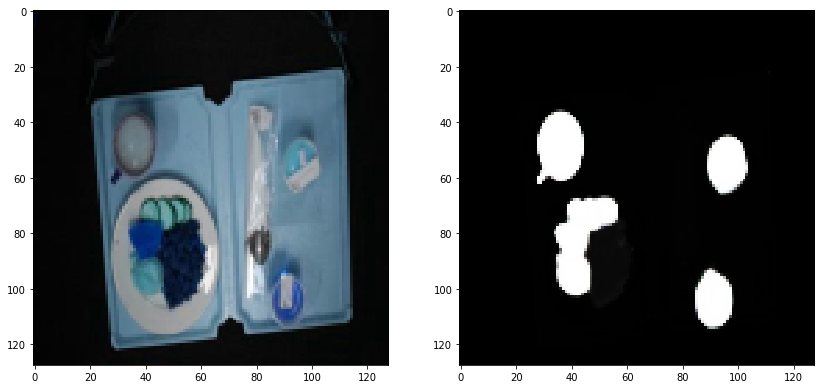

In [15]:
n = 7

plt.figure(figsize=(14, 7))

ax = plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(test_image[n]))

ax = plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(results[n]))